In [3]:
from importlib import reload
import json
import pretty_midi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# check gpu
print(tf..device_lib.list_local_devices())

In [83]:
import modules.midiMethods as midiMethods
reload(midiMethods)
from modules.midiMethods import *

import modules.dataMethods as dataMethods
reload(dataMethods)
from modules.dataMethods import *

import modules.models as models
reload(models)

import modules.mlClasses as mlClasses
reload(mlClasses)


<module 'modules.mlClasses' from '/home/ubuntu/music-ml/380-music-representation/modules/mlClasses.py'>

In [3]:
# if needed, read in filenames... specify if validation or test
maestro = pd.read_csv('training_data/maestro-v2.0.0withPeriod.csv', index_col=0)
filenames = list(maestro[maestro['train'] == 'test']['midi_filename'])

In [5]:
# store examples in json format
with open('training_data/note_bin_v1/nb_256_train0.95.json', 'w') as f:
    json.dump(train_95, f)

In [79]:
# or read them in
with open('training_data/note_bin_v1/nb_256_train1.00.json', 'r') as f:
    examples = json.load(f)
with open('training_data/note_bin_v1/nb_256_val.json', 'r') as f:
    val = json.load(f)

In [ ]:
ex_c = nb_data2chroma(np.array(examples))
val_c = nb_data2chroma(np.array(val))

In [85]:
ex_c[0]

TypeError: 'NoneType' object is not subscriptable

In [17]:
# build simple model
# excellent example of recurrent model here https://www.tensorflow.org/tutorials/text/text_generation
hidden_state = 512
lstm_layers = 3
seq_length = len(examples[0]) - 1
model2 = models.create_model1(hidden_state_size=hidden_state, lstm_layers=lstm_layers,
                              seq_length=seq_length)
training_generator = mlClasses.DataGenerator(examples, augment=True)
val_gen = mlClasses.DataGenerator(val, augment=False)

W0117 08:14:44.007811 140491241768768 deprecation.py:506] From /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "3layerLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 6)]     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 88)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 10)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 60)      0           input_1[0][0]                    
_________________________________________________________________________________________

In [19]:
model2.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# checkpoint = tf.keras.callbacks.ModelCheckpoint("weights/model1/{epoch:02d}-{train_loss:.2f}.hdf5", monitor='train_loss', verbose=2, save_best_only=True, save_weights_only=True)
epochs=50
history2 = model2.fit_generator(training_generator, validation_data=val_gen, epochs=epochs)
model2.save_weights(f'models/nbmodel3/model{epochs}e{hidden_state}ss{lstm_layers}l.h5')
with open(f'models/nbmodel3/history{epochs}ePd.json', 'w') as f:
    json.dump(pd.DataFrame(history.history).to_json(), f)


Epoch 1/20
322/322 [==============================] - 237s 736ms/step - loss: 13.1786 - dense_6_loss: 3.8935 - dense_7_loss: 0.0925 - dense_8_loss: 2.8613 - dense_9_loss: 0.6869 - dense_10_loss: 2.9975 - dense_11_loss: 2.6470 - dense_6_accuracy: 0.0449 - dense_7_accuracy: 0.9827 - dense_8_accuracy: 0.2096 - dense_9_accuracy: 0.7747 - dense_10_accuracy: 0.1366 - dense_11_accuracy: 0.1310 - val_loss: 12.2064 - val_dense_6_loss: 3.6095 - val_dense_7_loss: 0.0771 - val_dense_8_loss: 2.7222 - val_dense_9_loss: 0.5180 - val_dense_10_loss: 2.7510 - val_dense_11_loss: 2.5287 - val_dense_6_accuracy: 0.0763 - val_dense_7_accuracy: 0.9830 - val_dense_8_accuracy: 0.2281 - val_dense_9_accuracy: 0.8299 - val_dense_10_accuracy: 0.1698 - val_dense_11_accuracy: 0.1484
Epoch 2/20
322/322 [==============================] - 236s 733ms/step - loss: 11.6700 - dense_6_loss: 3.4521 - dense_7_loss: 0.0583 - dense_8_loss: 2.5982 - dense_9_loss: 0.4496 - dense_10_loss: 2.6230 - dense_11_loss: 2.4890 - dense_6_ac

In [20]:
# This works just like this:
import modules.models as models
reload(models)

<module 'modules.models' from '/home/ubuntu/music-ml/380-music-representation/modules/models.py'>

In [ ]:
# tf.train.latest_checkpoint('weights\first_attempt')
prediction_model = models.create_model1(batch_size=1, stateful=True, hidden_state_size=hidden_state, lstm_layers=lstm_layers)

In [ ]:
prediction_model.load_weights('weights/note_bin/model2_60epochs512state3layer.h5')
for i in range(1,5):
    temperatures = [0.02 + i * 0.003] * 6
    # temperatures = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
    # input_notes = [[44,0,0,4,3,20], [48,0,0,4,3,20], [51,0,0,3,3,20],[56,0,5,3,3,20]]
    input_notes = [[40,0,3,3,3,10],[42,3,3,3,3,10],[44,3,3,3,3,10],[45,3,3,3,3,10],[40,3,3,3,3,10],[44,0,0,3,3,10],[47,0,0,3,3,10],[52,0,7,3,3,10]]
    new_seq_length = 512
    new_seq = models.generate_music(prediction_model, new_seq_length, temperatures, input_notes)
    ns = [[int(a) for a in note] for note in new_seq]
    pm = note_bin2pm(ns)
    pm.write(f'midi/model512ss3l/60epochs/scale{new_seq_length}{temperatures[0]}.mid')

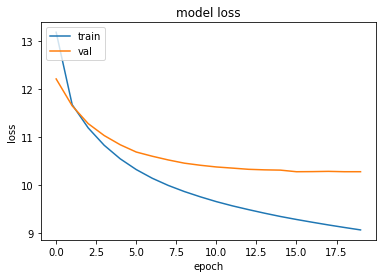

In [22]:
models.plt_metric(history2)


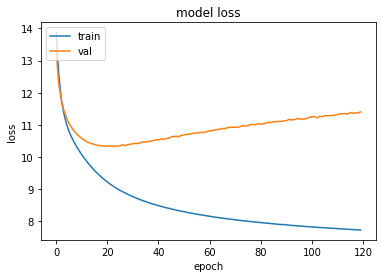

In [4]:
import ast
with open(f'models/nbmodel3/history120eStr.json', 'r') as f:
    hist = ast.literal_eval(json.load(f))
metric = 'loss'
# print(hist)
plt.plot(hist[metric])
plt.plot(hist['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

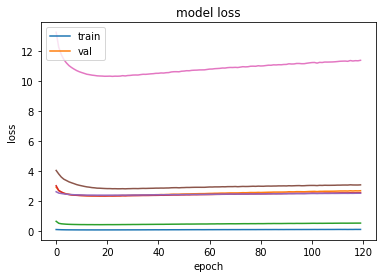

In [8]:
pm = 
metric = 'loss'
# print(hist)
plt.plot(hist['val_dense_1_' + metric])
plt.plot(hist['val_dense_2_' + metric])
plt.plot(hist['val_dense_3_' + metric])
plt.plot(hist['val_dense_4_' + metric])
plt.plot(hist['val_dense_5_' + metric])
plt.plot(hist['val_dense_' + metric])
plt.plot(hist['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [75]:
pm = pretty_midi.PrettyMIDI('midi/basic_test.mid')
nb1 = pm2note_bin(pm)
pm = pretty_midi.PrettyMIDI('midi/chromtest.mid')
nb2 = pm2note_bin(pm)

# ND = 0
# durations = 0
# shifts = 0
# NS = 0
# for note in nb:
#     if note[1] == 0 and note[2] == 0:
#         shifts +=1
#     else:
#         ND +=1
#     if note[3] and note[4] == 0:
#         durations += 1
#     else:
#         NS +=1
# print(durations)
# print(shifts)
# print(NS)
# print(ND)
    
               

In [77]:
nb2chroma(nb2)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.,

In [62]:
a = np.array([1,2,3,2,3,4])
np.where(a == 2)[0] % 2

array([1, 1])